<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 3.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


In [ ]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-01-26 14:10:38--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-01-26 14:10:38--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  40.2MB/s    in 12s     

2023-01-26 14:10:50 (38.6 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [ ]:
!unzip -q ModelNet10.zip;

In [4]:
import os

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


100%|██████████| 101/101 [02:29<00:00,  1.48s/it]


In [5]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [ ]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [77]:
from collections import OrderedDict
class BatchVoxNet(nn.Module):
    def __init__(self, n_classes=10, data_size=32):
        super().__init__()
        self.n_classes = n_classes
        self.data_size = data_size
        input_shape = (self.data_size,self.data_size,self.data_size)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('pool1', torch.nn.MaxPool3d(2)),
            ('drop5', torch.nn.Dropout(p=0.4)),
            ('conv3d_3', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu3', torch.nn.ReLU()),
            ('batch3', torch.nn.BatchNorm3d(32)),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop5', torch.nn.Dropout(p=0.4))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, self.n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

In [78]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel()
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self):
      self.model = BatchVoxNet()
      #self.model = VoxNet()
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.loss_fn = nn.CrossEntropyLoss()
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
        
  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [1]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'BatchVoxNet()'
}    

trainer = VoxNet_Trainer(training_hyperparameters)
trainer.train()

NameError: ignored

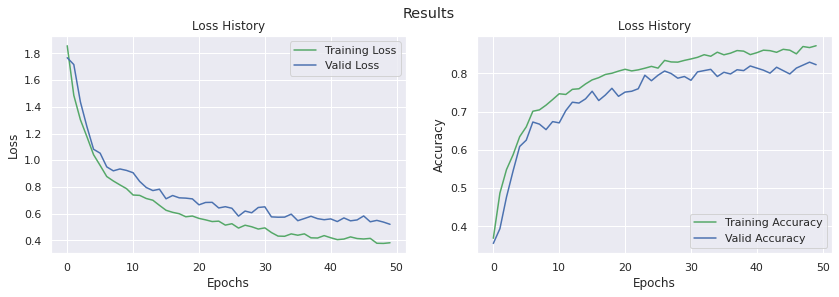

In [75]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

trainer.showResults()

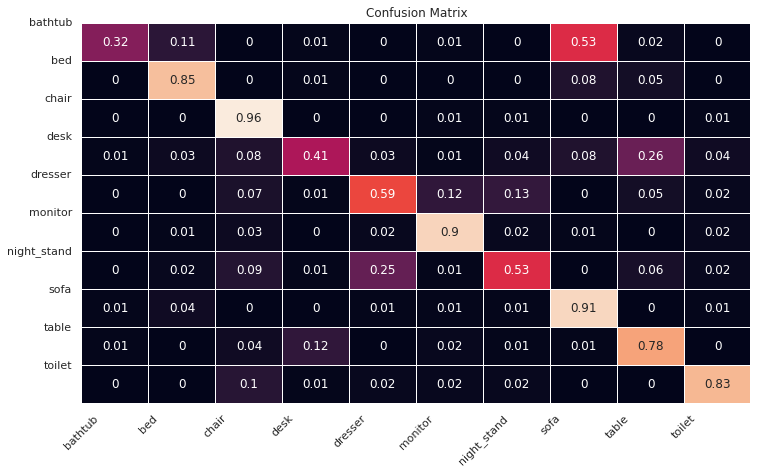

In [76]:
trainer.generateConfusionMatrix()

In [ ]:
trainer.getPerClassAccuracy()

In [ ]:
trainer.missing_data_test()

In [ ]:
trainer.draw_voxels()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 50,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

124.71875


Train loss: 1.0691629648208618: : 124it [01:19,  1.56it/s]
29it [00:10,  2.71it/s]


epoch:  1 / 50
time: 90.06 seconds
train-loss: 1.66, train-acc: 44.35%
valid-loss: 1.52, valid-acc: 44.60%



Train loss: 0.8261380195617676: : 124it [01:18,  1.58it/s]
29it [00:10,  2.79it/s]


epoch:  2 / 50
time: 88.74 seconds
train-loss: 1.21, train-acc: 57.23%
valid-loss: 1.23, valid-acc: 54.85%



Train loss: 0.5549680590629578: : 124it [01:18,  1.59it/s]
29it [00:10,  2.73it/s]


epoch:  3 / 50
time: 88.74 seconds
train-loss: 1.04, train-acc: 63.91%
valid-loss: 1.06, valid-acc: 60.02%



Train loss: 0.8094271421432495: : 124it [01:19,  1.56it/s]
29it [00:10,  2.66it/s]


epoch:  4 / 50
time: 90.45 seconds
train-loss: 0.89, train-acc: 69.53%
valid-loss: 0.97, valid-acc: 64.76%



Train loss: 0.8933238983154297: : 124it [01:18,  1.58it/s]
29it [00:10,  2.73it/s]


epoch:  5 / 50
time: 89.23 seconds
train-loss: 0.81, train-acc: 72.43%
valid-loss: 0.84, valid-acc: 68.94%



Train loss: 0.833092987537384: : 124it [01:18,  1.59it/s]
29it [00:10,  2.76it/s]


epoch:  6 / 50
time: 88.53 seconds
train-loss: 0.74, train-acc: 74.19%
valid-loss: 0.87, valid-acc: 70.04%



Train loss: 0.9623559713363647: : 124it [01:19,  1.56it/s]
29it [00:10,  2.73it/s]


epoch:  7 / 50
time: 90.16 seconds
train-loss: 0.69, train-acc: 76.11%
valid-loss: 0.78, valid-acc: 71.92%



Train loss: 0.500974714756012: : 124it [01:18,  1.58it/s]
29it [00:11,  2.43it/s]


epoch:  8 / 50
time: 90.22 seconds
train-loss: 0.64, train-acc: 78.10%
valid-loss: 0.76, valid-acc: 72.03%



Train loss: 0.6374151110649109: : 124it [01:19,  1.56it/s]
29it [00:10,  2.77it/s]


epoch:  9 / 50
time: 89.76 seconds
train-loss: 0.61, train-acc: 79.59%
valid-loss: 0.69, valid-acc: 75.99%



Train loss: 0.5610416531562805: : 124it [01:19,  1.57it/s]
29it [00:10,  2.74it/s]


epoch: 10 / 50
time: 89.79 seconds
train-loss: 0.59, train-acc: 80.54%
valid-loss: 0.70, valid-acc: 75.00%



Train loss: 0.41097909212112427: : 124it [01:18,  1.58it/s]
29it [00:10,  2.74it/s]


epoch: 11 / 50
time: 89.20 seconds
train-loss: 0.55, train-acc: 81.80%
valid-loss: 0.75, valid-acc: 75.11%



Train loss: 0.46033212542533875: : 124it [01:18,  1.59it/s]
29it [00:10,  2.70it/s]


epoch: 12 / 50
time: 88.86 seconds
train-loss: 0.52, train-acc: 82.66%
valid-loss: 0.63, valid-acc: 78.30%



Train loss: 0.41034334897994995: : 124it [01:19,  1.56it/s]
29it [00:10,  2.76it/s]


epoch: 13 / 50
time: 89.96 seconds
train-loss: 0.52, train-acc: 81.78%
valid-loss: 0.64, valid-acc: 76.65%



Train loss: 0.6342290043830872: : 124it [01:18,  1.58it/s]
29it [00:10,  2.68it/s]


epoch: 14 / 50
time: 89.13 seconds
train-loss: 0.50, train-acc: 83.42%
valid-loss: 0.67, valid-acc: 75.55%



Train loss: 0.31583547592163086: : 124it [01:19,  1.56it/s]
29it [00:10,  2.72it/s]


epoch: 15 / 50
time: 90.20 seconds
train-loss: 0.49, train-acc: 83.82%
valid-loss: 0.56, valid-acc: 81.17%



Train loss: 0.2974761128425598: : 124it [01:19,  1.56it/s]
29it [00:10,  2.74it/s]


epoch: 16 / 50
time: 90.28 seconds
train-loss: 0.43, train-acc: 86.19%
valid-loss: 0.54, valid-acc: 80.07%



Train loss: 0.45925629138946533: : 124it [01:19,  1.57it/s]
29it [00:10,  2.75it/s]


epoch: 17 / 50
time: 89.68 seconds
train-loss: 0.42, train-acc: 86.49%
valid-loss: 0.53, valid-acc: 81.17%



Train loss: 0.4046476185321808: : 124it [01:18,  1.57it/s]
29it [00:10,  2.71it/s]


epoch: 18 / 50
time: 89.49 seconds
train-loss: 0.41, train-acc: 86.19%
valid-loss: 0.59, valid-acc: 80.51%



Train loss: 0.44116050004959106: : 124it [01:20,  1.55it/s]
29it [00:10,  2.74it/s]


epoch: 19 / 50
time: 90.67 seconds
train-loss: 0.41, train-acc: 86.62%
valid-loss: 0.55, valid-acc: 82.16%



Train loss: 0.44747233390808105: : 124it [01:18,  1.58it/s]
29it [00:10,  2.69it/s]


epoch: 20 / 50
time: 89.17 seconds
train-loss: 0.37, train-acc: 87.30%
valid-loss: 0.65, valid-acc: 79.85%



Train loss: 0.48494040966033936: : 124it [01:18,  1.59it/s]
29it [00:10,  2.75it/s]


epoch: 21 / 50
time: 88.78 seconds
train-loss: 0.38, train-acc: 87.58%
valid-loss: 0.51, valid-acc: 82.27%



Train loss: 0.31788742542266846: : 124it [01:18,  1.59it/s]
29it [00:11,  2.51it/s]


epoch: 22 / 50
time: 89.64 seconds
train-loss: 0.37, train-acc: 87.58%
valid-loss: 0.51, valid-acc: 82.38%



Train loss: 0.27749988436698914: : 124it [01:17,  1.59it/s]
29it [00:10,  2.80it/s]


epoch: 23 / 50
time: 88.23 seconds
train-loss: 0.35, train-acc: 88.23%
valid-loss: 0.50, valid-acc: 82.49%



Train loss: 0.23085524141788483: : 124it [01:17,  1.60it/s]
29it [00:10,  2.81it/s]


epoch: 24 / 50
time: 87.62 seconds
train-loss: 0.35, train-acc: 88.26%
valid-loss: 0.49, valid-acc: 83.92%



Train loss: 0.3431478440761566: : 124it [01:17,  1.61it/s]
29it [00:10,  2.79it/s]


epoch: 25 / 50
time: 87.56 seconds
train-loss: 0.36, train-acc: 88.00%
valid-loss: 0.50, valid-acc: 82.82%



Train loss: 0.5132175087928772: : 124it [01:17,  1.61it/s]
29it [00:10,  2.83it/s]


epoch: 26 / 50
time: 87.51 seconds
train-loss: 0.35, train-acc: 87.93%
valid-loss: 0.51, valid-acc: 83.70%



Train loss: 0.3980346918106079: : 124it [01:16,  1.63it/s]
29it [00:10,  2.74it/s]


epoch: 27 / 50
time: 86.89 seconds
train-loss: 0.34, train-acc: 88.21%
valid-loss: 0.46, valid-acc: 84.36%



Train loss: 0.3833869695663452: : 124it [01:15,  1.64it/s]
29it [00:10,  2.83it/s]


epoch: 28 / 50
time: 85.92 seconds
train-loss: 0.34, train-acc: 88.08%
valid-loss: 0.50, valid-acc: 82.82%



Train loss: 0.45445138216018677: : 124it [01:17,  1.60it/s]
29it [00:10,  2.82it/s]


epoch: 29 / 50
time: 87.74 seconds
train-loss: 0.33, train-acc: 88.94%
valid-loss: 0.51, valid-acc: 84.69%



Train loss: 0.3026057779788971: : 124it [01:15,  1.63it/s]
29it [00:10,  2.84it/s]


epoch: 30 / 50
time: 86.17 seconds
train-loss: 0.32, train-acc: 89.24%
valid-loss: 0.50, valid-acc: 84.03%



Train loss: 0.404910683631897: : 124it [01:16,  1.63it/s]
29it [00:10,  2.81it/s]


epoch: 31 / 50
time: 86.42 seconds
train-loss: 0.32, train-acc: 88.61%
valid-loss: 0.52, valid-acc: 85.13%



Train loss: 0.2319575995206833: : 124it [01:16,  1.62it/s]
29it [00:11,  2.54it/s]


epoch: 32 / 50
time: 87.87 seconds
train-loss: 0.29, train-acc: 89.69%
valid-loss: 0.48, valid-acc: 82.05%



Train loss: 0.11163557320833206: : 124it [01:15,  1.63it/s]
29it [00:10,  2.79it/s]


epoch: 33 / 50
time: 86.36 seconds
train-loss: 0.28, train-acc: 90.83%
valid-loss: 0.47, valid-acc: 84.80%



Train loss: 0.32356587052345276: : 124it [01:16,  1.62it/s]
29it [00:10,  2.75it/s]


epoch: 34 / 50
time: 87.14 seconds
train-loss: 0.28, train-acc: 90.42%
valid-loss: 0.45, valid-acc: 85.13%



Train loss: 0.29891782999038696: : 124it [01:16,  1.61it/s]
29it [00:10,  2.79it/s]


epoch: 35 / 50
time: 87.40 seconds
train-loss: 0.29, train-acc: 90.35%
valid-loss: 0.48, valid-acc: 84.36%



Train loss: 0.35034605860710144: : 124it [01:20,  1.54it/s]
29it [00:10,  2.73it/s]


epoch: 36 / 50
time: 91.20 seconds
train-loss: 0.28, train-acc: 90.65%
valid-loss: 0.45, valid-acc: 84.25%



Train loss: 0.30400604009628296: : 124it [01:17,  1.60it/s]
29it [00:10,  2.76it/s]


epoch: 37 / 50
time: 87.83 seconds
train-loss: 0.27, train-acc: 90.47%
valid-loss: 0.46, valid-acc: 85.24%



Train loss: 0.3647148311138153: : 124it [01:17,  1.60it/s]
29it [00:10,  2.79it/s]


epoch: 38 / 50
time: 87.85 seconds
train-loss: 0.27, train-acc: 91.13%
valid-loss: 0.44, valid-acc: 85.35%



Train loss: 0.36395105719566345: : 124it [01:18,  1.58it/s]
29it [00:10,  2.77it/s]


epoch: 39 / 50
time: 88.94 seconds
train-loss: 0.28, train-acc: 90.25%
valid-loss: 0.44, valid-acc: 85.02%



Train loss: 0.20288199186325073: : 124it [01:17,  1.60it/s]
29it [00:10,  2.78it/s]


epoch: 40 / 50
time: 88.16 seconds
train-loss: 0.27, train-acc: 90.50%
valid-loss: 0.45, valid-acc: 85.57%



Train loss: 0.12280852347612381: : 124it [01:18,  1.59it/s]
29it [00:10,  2.75it/s]


epoch: 41 / 50
time: 88.70 seconds
train-loss: 0.25, train-acc: 91.58%
valid-loss: 0.49, valid-acc: 84.80%



Train loss: 0.38666799664497375: : 124it [01:19,  1.56it/s]
29it [00:10,  2.76it/s]


epoch: 42 / 50
time: 90.08 seconds
train-loss: 0.25, train-acc: 91.10%
valid-loss: 0.46, valid-acc: 84.80%



Train loss: 0.18064437806606293: : 124it [01:17,  1.59it/s]
29it [00:10,  2.74it/s]


epoch: 43 / 50
time: 88.48 seconds
train-loss: 0.26, train-acc: 91.08%
valid-loss: 0.45, valid-acc: 85.35%



Train loss: 0.29642364382743835: : 124it [01:18,  1.59it/s]
29it [00:10,  2.75it/s]


epoch: 44 / 50
time: 88.73 seconds
train-loss: 0.26, train-acc: 91.00%
valid-loss: 0.44, valid-acc: 84.58%



Train loss: 0.23256134986877441: : 124it [01:18,  1.57it/s]
29it [00:10,  2.79it/s]


epoch: 45 / 50
time: 89.18 seconds
train-loss: 0.25, train-acc: 91.38%
valid-loss: 0.42, valid-acc: 86.34%



Train loss: 0.2312694936990738: : 124it [01:17,  1.60it/s]
29it [00:10,  2.74it/s]


epoch: 46 / 50
time: 88.19 seconds
train-loss: 0.25, train-acc: 91.26%
valid-loss: 0.46, valid-acc: 83.59%



Train loss: 0.2791285812854767: : 124it [01:17,  1.59it/s]
29it [00:10,  2.77it/s]


epoch: 47 / 50
time: 88.37 seconds
train-loss: 0.25, train-acc: 91.10%
valid-loss: 0.48, valid-acc: 85.24%



Train loss: 0.26043036580085754: : 124it [01:18,  1.58it/s]
29it [00:10,  2.79it/s]


epoch: 48 / 50
time: 89.04 seconds
train-loss: 0.24, train-acc: 91.86%
valid-loss: 0.46, valid-acc: 85.24%



Train loss: 0.1650044322013855: : 124it [01:16,  1.61it/s]
29it [00:10,  2.74it/s]


epoch: 49 / 50
time: 87.55 seconds
train-loss: 0.24, train-acc: 91.73%
valid-loss: 0.42, valid-acc: 86.45%



Train loss: 0.16963419318199158: : 124it [01:17,  1.61it/s]
29it [00:10,  2.76it/s]

epoch: 50 / 50
time: 87.55 seconds
train-loss: 0.23, train-acc: 91.94%
valid-loss: 0.44, valid-acc: 85.79%



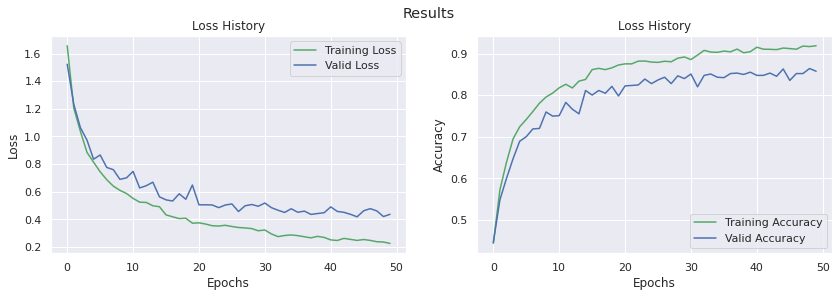

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

trainer2.showResults()

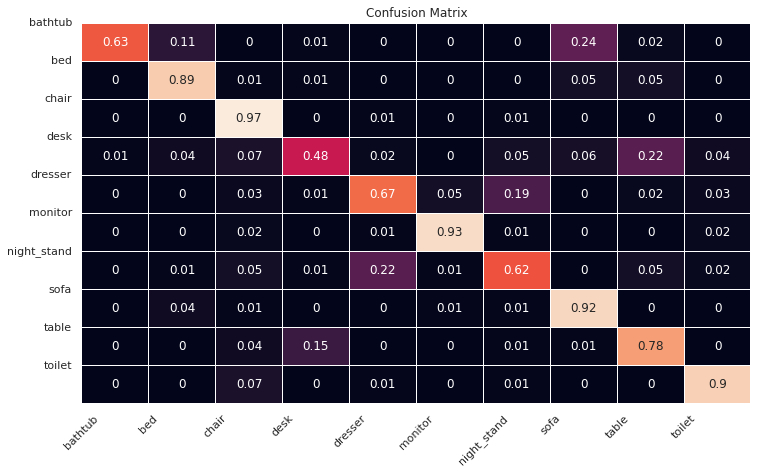

In [ ]:
trainer2.generateConfusionMatrix()